# Detection — Grounding-DINO
**Author:** Sayed Pedram Haeri Boroujeni  
**Position:** PhD Student, Clemson University  
**Affiliation:** Department of Computer Science  
**Email:** shaerib@g.clemson.edu  
**Date Created:** October 10, 2025  

##### 1. Importing Required Libraries

In [13]:
import os
import torch
import numpy as np
import random
from PIL import Image
import urllib.request
import cv2
import supervision as sv
from tqdm import tqdm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from groundingdino.util.inference import Model
import seaborn as sns
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from groundingdino.util.inference import Model, load_image, predict

os.chdir(r"C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/model_dino")

##### 2. Clone Grounding-DINO model and Weights

In [2]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
#%cd GroundingDINO
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\model_dino


fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


In [3]:
os.makedirs("weights", exist_ok=True)
print("weights folder created:", os.path.exists("weights"))

weights folder created: True


##### 3. Checking GPU Availability

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Device Name: {torch.cuda.get_device_name()}")
else:
    print("CUDA is not available on this system.")

CUDA Available: True
CUDA Version: 12.6
Number of GPUs: 1
Device Name: NVIDIA RTX A5000


##### 4. Reproducibility

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

set_seed(15)

##### 4. Configuration

In [6]:
weights_url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
weights_path = os.path.join("weights", "groundingdino_swint_ogc.pth")

if not os.path.exists(weights_path):
    print("Downloading weights ... please wait (~700 MB)")
    urllib.request.urlretrieve(weights_url, weights_path)
else:
    print("Weights already exist.")

print("✅ Weights available at:", weights_path)

Weights already exist.
✅ Weights available at: weights\groundingdino_swint_ogc.pth


In [7]:
CONFIG_PATH = os.path.join(os.getcwd(), "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_PATH = os.path.join(os.getcwd(), "weights", "groundingdino_swint_ogc.pth")

assert os.path.exists(CONFIG_PATH), f"Missing config file: {CONFIG_PATH}"
assert os.path.exists(WEIGHTS_PATH), f"Missing weights file: {WEIGHTS_PATH}"

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)
print("✅ Grounding DINO model loaded successfully.")

C:\Users\shaerib\AppData\Local\anaconda3\envs\AV_Fusion\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
✅ Grounding DINO model loaded successfully.


##### 5. Datasets and Classes

In [8]:
# === CONFIG ===
data_dir = r"C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/FireNet"
test_img_dir = os.path.join(data_dir, "test", "images")
test_lbl_dir = os.path.join(data_dir, "test", "labels")

# Modify this list to reflect the classes your model should detect
# classes = ["fire", "flame", "smoke", "burning"]
classes = ["fire"]

# Caption to be used as input for Grounding DINO (text prompt)
caption = ", ".join(classes)   # Example: "fire, flame, smoke, burning"


# HELPER: Parse VOC XML to YOLO-like format
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)
    boxes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        if cls not in classes:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find("bndbox")
        x_min = int(float(xmlbox.find("xmin").text))
        y_min = int(float(xmlbox.find("ymin").text))
        x_max = int(float(xmlbox.find("xmax").text))
        y_max = int(float(xmlbox.find("ymax").text))
        boxes.append([x_min, y_min, x_max, y_max, cls_id])
    return boxes, w, h

##### 6. Model Initialization

In [9]:
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

results = []
annotator = sv.BoxAnnotator()

# create a folder for visual results
save_dir = os.path.join(data_dir, "dino_results")
os.makedirs(save_dir, exist_ok=True)

for img_file in tqdm(os.listdir(test_img_dir)):
    if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(test_img_dir, img_file)
    label_path = os.path.join(test_lbl_dir, os.path.splitext(img_file)[0] + ".xml")

    if not os.path.exists(label_path):
        continue

    # Load ground truth
    gt_boxes, w, h = parse_voc_xml(label_path)

    # Run model
    image = cv2.imread(img_path)
    detections = model.predict_with_classes(
        image=image,
        classes=classes,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = detections.with_nms()

    labels = []
    for i in range(len(detections.xyxy)):
        cls_id = detections.class_id[i]
        conf = detections.confidence[i]
        if cls_id is None or cls_id >= len(classes):
            labels.append(f"unknown {conf:.2f}")
        else:
            labels.append(f"{classes[int(cls_id)]} {conf:.2f}")

    annotated = annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
    cv2.imwrite(os.path.join(save_dir, img_file), annotated)

    # Save results for evaluation
    for i in range(len(detections.xyxy)):
        x1, y1, x2, y2 = detections.xyxy[i]
        conf = detections.confidence[i]
        cls_id = detections.class_id[i]
        results.append({
            "image": img_file,
            "pred_box": [float(x1), float(y1), float(x2), float(y2)],
            "pred_cls": int(cls_id) if cls_id is not None else -1,
            "conf": float(conf),
            "gt_boxes": gt_boxes
        })

C:\Users\shaerib\AppData\Local\anaconda3\envs\AV_Fusion\Lib\site-packages\transformers\modeling_utils.py:1625: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\shaerib\AppData\Local\anaconda3\envs\AV_Fusion\Lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\shaerib\AppData\Local\anaconda3\envs\AV_Fusion\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
C:\Users\shaerib\AppData\Local\anaconda3\envs\AV_Fusion\Lib\site-packa

##### 7. Quantitative Evaluation

In [14]:
def compute_iou(box1, box2):
    """Compute IoU between two boxes [x1, y1, x2, y2]."""
    xA, yA = max(box1[0], box2[0]), max(box1[1], box2[1])
    xB, yB = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0

ious, preds, gts = [], [], []
iou_threshold = 0.5  # you can tune this

for r in results:
    gt_boxes = r["gt_boxes"]
    if not gt_boxes:
        continue

    best_iou = 0
    for gt in gt_boxes:
        iou = compute_iou(r["pred_box"], gt[:4])
        best_iou = max(best_iou, iou)

    ious.append(best_iou)
    preds.append(1 if best_iou >= iou_threshold else 0)
    gts.append(1 if len(gt_boxes) > 0 else 0)

precision = precision_score(gts, preds, zero_division=0)
recall = recall_score(gts, preds, zero_division=0)
f1 = f1_score(gts, preds, zero_division=0)
accuracy = accuracy_score(gts, preds)
mean_iou = np.mean(ious) if ious else 0

print("📊 Evaluation Results:")
print(f"Mean IoU     : {mean_iou:.4f}")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1-Score     : {f1:.4f}")


📊 Evaluation Results:
Mean IoU     : 0.7074
Accuracy     : 0.8600
Precision    : 1.0000
Recall       : 0.8600
F1-Score     : 0.9247


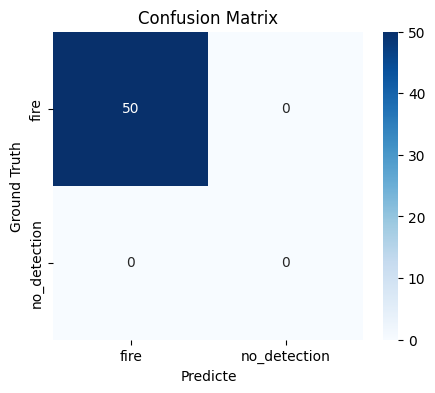

In [16]:
y_true, y_pred = [], []

for r in results:
    gt_boxes = r["gt_boxes"]
    if not gt_boxes:
        continue
    gt_cls = gt_boxes[0][4]  
    pred_cls = r["pred_cls"]
    y_true.append(gt_cls)
    y_pred.append(pred_cls)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicte")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

##### 8. Qualitative Evaluation

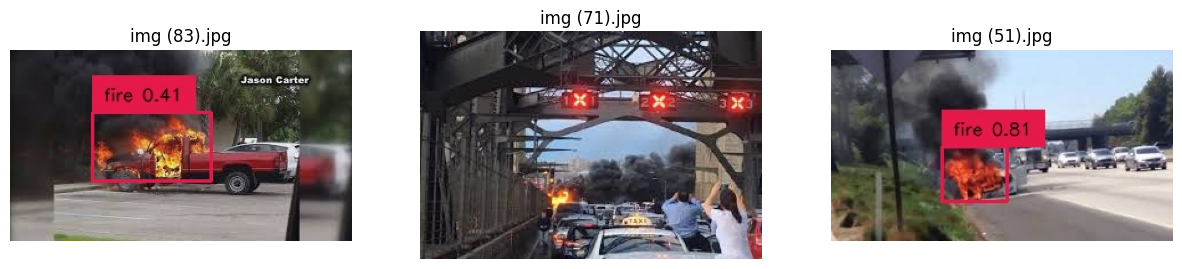

In [17]:
sample_imgs = random.sample(os.listdir(save_dir), k=3)
plt.figure(figsize=(15,5))
for i, fname in enumerate(sample_imgs):
    img_path = os.path.join(save_dir, fname)
    plt.subplot(1,3,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis("off")
    plt.title(fname)
plt.show()

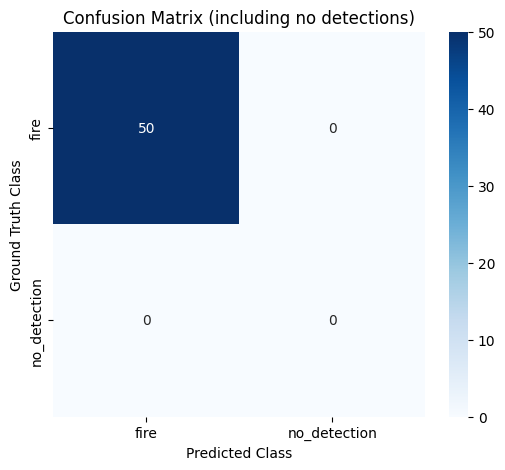

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Add a "no detection" class to handle missed detections
if "no_detection" not in classes:
    classes.append("no_detection")

no_det_cls_id = len(classes) - 1

y_true, y_pred = [], []

for r in results:
    gt_boxes = r["gt_boxes"]

    # If the image has no ground truth boxes, skip it (optional)
    if not gt_boxes:
        continue

    gt_cls = gt_boxes[0][4]   # first ground-truth class
    pred_cls = r["pred_cls"]

    # If there was no detected class, assign it as "no detection"
    if pred_cls is None or pred_cls < 0:
        pred_cls = no_det_cls_id

    y_true.append(gt_cls)
    y_pred.append(pred_cls)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

# --- Visualization ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Class")
plt.ylabel("Ground Truth Class")
plt.title("Confusion Matrix (including no detections)")
plt.show()
